1. Obtain cropped images from zarr file, max project them and save them back to the zarr file
Only need to run this cell once! Once the cropped images are saved as max projections go directly to the next cell.

Load images from zarr to torch dataset

In [7]:
import zarr
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.preprocessing import OneHotEncoder

TREATMENTS = ['8nMActD', 'DMSO', '1uMdoxo', 'CX5461', '5uMflavo', '800nMActD', '10uMmg132', '10uMwort']

class ZarrImageDataset(Dataset):
    def __init__(self, zarr_path, transform=None):
        self.root = zarr.open(zarr_path, mode='r')
        self.transform = transform
        self.images = []
        self.labels = []
        self.label_map = {name: idx for idx, name in enumerate(TREATMENTS)}

        # Load images and labels
        # map treatments to integer labels
        for treatment_name in self.root.group_keys():
            treatment_group = self.root[treatment_name]['cimages_max']
            print(f"the treatment group shape for treatment {treatment_name} is {treatment_group.shape}")
            self.images.append(treatment_group[:])
            self.labels.extend([self.label_map[treatment_name]] * treatment_group.shape[0])

        self.images = np.concatenate(self.images)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        # Convert to torch tensor
        img_tensor = torch.tensor(img, dtype=torch.float32)
        label_tensor = torch.tensor(label, dtype=torch.long)

        if self.transform:
            img_tensor = self.transform(img_tensor)

        return img_tensor, label_tensor

# Call the function to create the dataset
zarr_path = '/mnt/efs/aimbl_2025/student_data/S-DD/LDM_treatments.zarr'
dataset = ZarrImageDataset(zarr_path)





the treatment group shape for treatment 1uMdoxo is (1062, 3, 128, 128)
the treatment group shape for treatment 10uMmg132 is (1183, 3, 128, 128)
the treatment group shape for treatment CX5461 is (2189, 3, 128, 128)
the treatment group shape for treatment 800nMActD is (1654, 3, 128, 128)
the treatment group shape for treatment 8nMActD is (1763, 3, 128, 128)
the treatment group shape for treatment DMSO is (2044, 3, 128, 128)
the treatment group shape for treatment 10uMwort is (1820, 3, 128, 128)
the treatment group shape for treatment 5uMflavo is (1493, 3, 128, 128)


Load trained ResNet18 as model using previous weights

In [8]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pretrained ResNet-18 model
model = models.resnet18()

# Modify the final fully connected layer and establish model parameters
num_epochs = 10
learning_rate = 0.001
batch_size = 1
num_classes = 8
model.fc = nn.Linear(model.fc.in_features, num_classes)
# print(model)

weights = torch.load("/mnt/efs/aimbl_2025/student_data/S-DD/nucleoli_restnet_trained-20250904-222636.pth")
model.load_state_dict(weights["nucleoli_resnet"])

model = model.to(device)

In [9]:

#Split dataset
# Total size of the dataset
total_size = len(dataset)

# Calculate split sizes
train_size = int(0.7 * total_size)
eval_size = int(0.2 * total_size)
test_size = total_size - train_size - eval_size  # Ensures full coverage

# Random split
train_dataset, eval_dataset, test_dataset = random_split(
    dataset,
    [train_size, eval_size, test_size],
    generator=torch.Generator().manual_seed(42))  # For reproducibility
print(f"The size of the train dataset is {len(train_dataset)}")
print(f"The size of the eval dataset is {len(eval_dataset)}")
print(f"The size of the test dataset is {len(test_dataset)}")


# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


The size of the train dataset is 9245
The size of the eval dataset is 2641
The size of the test dataset is 1322


Validating model

In [10]:
import tqdm
#load weights to run predictions

# Model validation function:
def validate_nucleoli_resnet(model, eval_loader, batch_size):
    model.eval()
    pbar = tqdm.tqdm(total=len(eval_dataset) // batch_size)
    predictions = []
    targets = []
    for batch_idx, (raw, target) in enumerate(eval_loader):
        raw = raw.to(device)
        output = model(raw)
        # loss = criterion(output, target)
        # history.append(loss.item())
        predictions.append(output.argmax().cpu().detach().numpy())
        targets.append(target)
        pbar.update(1)
    return predictions, targets


batch_size = 1
predictions, targets = validate_nucleoli_resnet(model, eval_loader, batch_size)


100%|██████████| 2641/2641 [00:10<00:00, 249.98it/s]


Visualize validation results using a confusion matrix

In [5]:
TREATMENTS = ['8nMActD', 'DMSO', '1uMdoxo', 'CX5461', '5uMflavo', '800nMActD', '10uMmg132', '10uMwort']

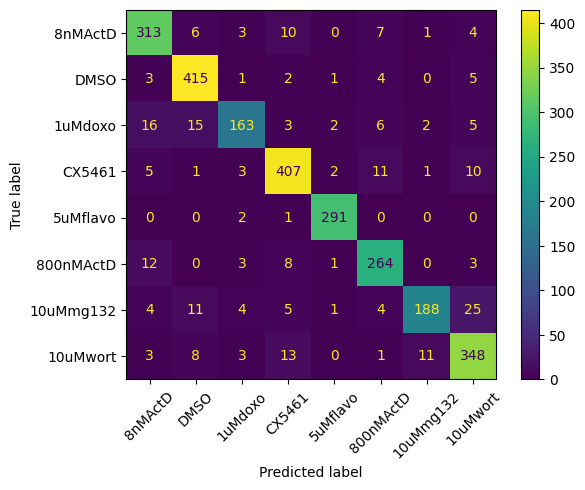

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(targets, predictions)
disp = ConfusionMatrixDisplay(cm, display_labels=TREATMENTS)
disp.plot(xticks_rotation = 45)

In [14]:
import matplotlib.pyplot as plt
disp.figure_.savefig('/mnt/efs/aimbl_2025/student_data/S-DD/nucleoli_restnet_trained-20250904-222636-confusionmatrix.png')

PCA of features extracted from the last layer. After talking with Diane, this does not seem super informative because we have no idea of what those features are. Best to compare them based on confusion matrix.

Future directions: run the models with the same train : test : val split and random seed to ensure we are comparing apples to apples.

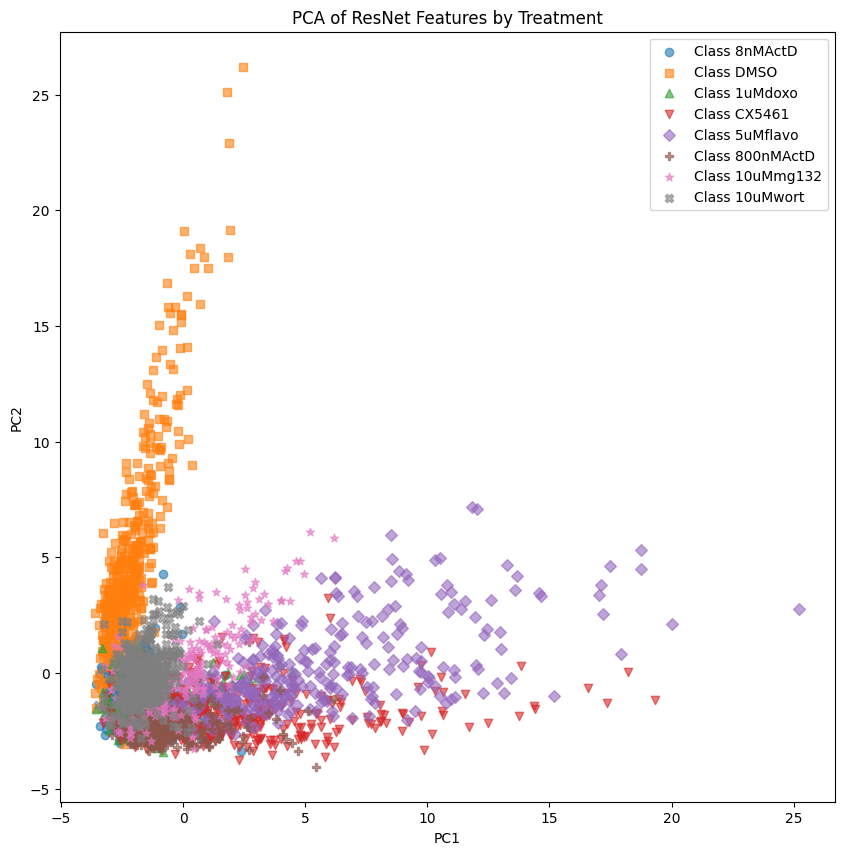

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Extract features from the penultimate layer of ResNet18 for eval set
def extract_features(model, eval_loader, device):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for imgs, lbls in eval_loader:
            imgs = imgs.to(device)
            # Forward pass up to the penultimate layer
            x = model.conv1(imgs)
            x = model.bn1(x)
            x = model.relu(x)
            x = model.maxpool(x)
            x = model.layer1(x)
            x = model.layer2(x)
            x = model.layer3(x)
            x = model.layer4(x)
            x = model.avgpool(x)
            x = torch.flatten(x, 1)
            features.append(x.cpu().numpy())
            labels.append(lbls.cpu().numpy())
    features = np.concatenate(features)
    labels = np.concatenate(labels).flatten()
    return features, labels

features, labels = extract_features(model, eval_loader, device)

# PCA
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)

# Plot the PCA
plt.figure(figsize=(10, 10))
markers = ['o', 's', '^', 'v', 'D', 'P', '*', 'X']
for i, treatment in enumerate(TREATMENTS):
    indices = labels == i
    plt.scatter(
        features_pca[indices, 0],
        features_pca[indices, 1],
        marker=markers[i],
        label=f"Class {treatment}",
        alpha=0.6
    )
plt.legend()
plt.title("PCA of ResNet Features by Treatment")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()